In [1]:
import numpy as np         
import pandas as pd        
import scipy  # модуль для работы со статистикой
from scipy import stats
import statsmodels
# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')    # стиль графиков
%matplotlib inline
%run f2forecast.py

In [2]:
data_df = pd.read_excel(r'../data/farsh.xlsx')

Text(0, 0.5, 'продажи')

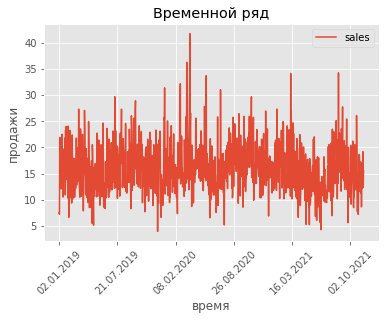

In [3]:
first_df = data_df.copy()
first_df.set_index('ds', inplace=True)
first_df.plot()
plt.title("Временной ряд")
plt.xlabel("время")
plt.tick_params(axis ='x', rotation = 45)
plt.ylabel("продажи")

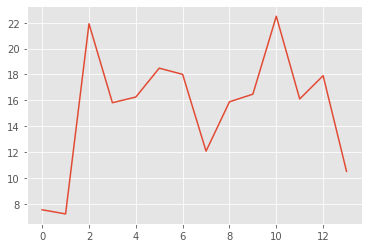

In [4]:
mean = np.mean(data_df.sales) # выборочное среднее
sigma = np.std(data_df.sales)
data_df = data_df[(data_df.sales > mean - 3*sigma) & (data_df.sales < mean + 3*sigma)]
sales = data_df.sales
dates = data_df.index
plt.plot(dates[:14], sales[:14])

Усредняем по неделям

In [38]:
data_df['ds'] = pd.to_datetime(data_df['ds'])
week_df = data_df.groupby([pd.Grouper(key='ds', freq='W-MON')])['sales'].mean().reset_index().sort_values('ds')
week_df = week_df.dropna()

Text(0, 0.5, 'продажи')

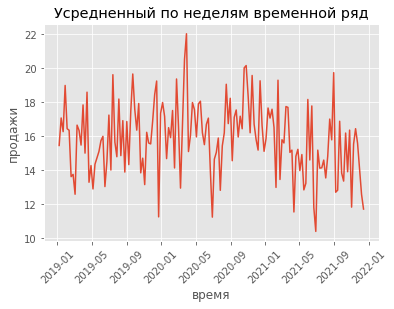

In [6]:
plt.plot(week_df.ds, week_df.sales)
plt.title("Усредненный по неделям временной ряд")
plt.xlabel("время")
plt.tick_params(axis ='x', rotation = 45)
plt.ylabel("продажи")

Проверка на стационарность
1) ACF - автокорреляционная функция 

In [7]:
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score

In [8]:
salesW = week_df['sales']

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

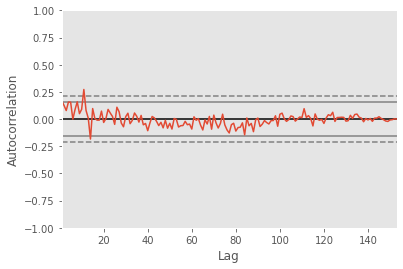

In [9]:
pd.plotting.autocorrelation_plot(salesW)

2

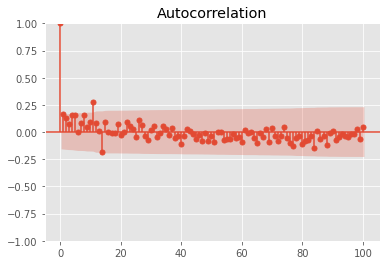

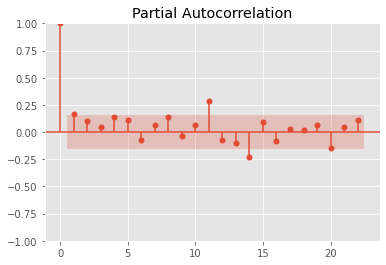

In [10]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(week_df.sales, lags=100)
plot_pacf(week_df.sales)
#plt.title("Усредненный по неделям временной ряд")
#plt.xlabel("время")
#plt.tick_params(axis ='x', rotation = 45)
#plt.ylabel("продажи")
1+1

Тесты на стационарность

In [13]:
test = sm.tsa.adfuller(week_df.sales)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print( 'единичных корней нет, ряд стационарен')

adf:  -2.3204984868309384
p-value:  0.1654420011560938
Critical values:  {'1%': -3.4782936965183815, '5%': -2.882567574015525, '10%': -2.5779830117488745}
есть единичные корни, ряд не стационарен


In [48]:
test = sm.tsa.adfuller(new_df.sales)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['1%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print( 'единичных корней нет, ряд стационарен')

adf:  -4.047333772804454
p-value:  0.0011819627482221344
Critical values:  {'1%': -3.4782936965183815, '5%': -2.882567574015525, '10%': -2.5779830117488745}
единичных корней нет, ряд стационарен


In [112]:
week_df.sales.describe()

count    153.000000
mean      80.526314
std        8.250464
min       58.640000
25%       75.031429
50%       80.351429
75%       86.791429
max      105.190000
Name: sales, dtype: float64

count - число наблюдений, которое есть без пропусков
mean - среднее значение
std - стандартное отклонение
min - минимум
max - максимум
50% - медиана (половина выборки больше неё, половина меньше)
25% - 25% квантиль (четверть выборки меньше, 75% больше)
75% - 75% квантиль

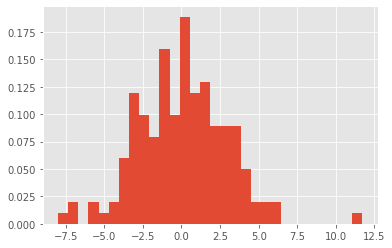

In [49]:
plt.hist(new_df.sales, bins=30,  density=True)
x = np.linspace(0, 100, 100)

Декомпозиция на основе тренда и сезонности

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#data_df = validate_series(data_df)
result_M = seasonal_decompose(week_df.sales, model='additive', period=48)

plt.rcParams.update({'figure.figsize': (15,15)})
result_M.plot().suptitle('Аддитивная модель')

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from adtk.data import validate_series
# data_df_temp = data_df[(data_df.sales <100 ) & (data_df.sales != 0)]
# data_df_temp = validate_series(data_df_temp)
result_M = seasonal_decompose(week_df.sales, model='multiplicative', period=48)

plt.rcParams.update({'figure.figsize': (15,15)})
result_M.plot().suptitle('Мультипликативная модель')

In [65]:
train_df=week_df[(week_df.ds > '2018') & (week_df.ds <'2021')]
train_df.set_index('ds', inplace=True)
train = train_df.sales

In [66]:
train_df_shifted=new_df[(new_df.ds > '2018') & (new_df.ds <'2021')]
train_df_shifted.set_index('ds', inplace=True)
train_shifted = train_df_shifted.sales

In [51]:
test_df=new_df[(new_df.ds >='2021')]
test_df.set_index('ds', inplace=True)
test = test_df.sales

SARIMA

График автокорреляции

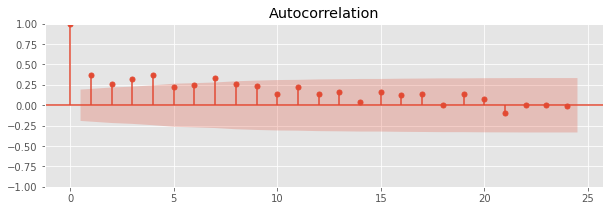

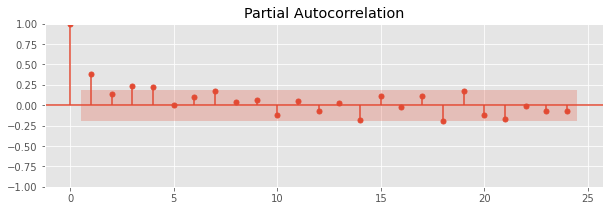

In [165]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train, lags=24)
plot_pacf(train, lags=24)
plt.show()

Подбор параметров модели

In [67]:
model = auto_arima(train_shifted, seasonal=True, m=48, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[48] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(0,0,0)(0,0,0)[48] intercept   : AIC=499.527, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[48] intercept   : AIC=479.497, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[48] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,0)(0,0,0)[48]             : AIC=497.527, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[48] intercept   : AIC=477.714, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[48] intercept   : AIC=479.498, Time=0.28 sec
 ARIMA(1,0,0)(1,0,1)[48] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(2,0,0)(0,0,0)[48] intercept   : AIC=472.107, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[48] intercept   : AIC=472.934, Time=0.43 sec
 ARIMA(2,0,0)(0,0,1)[48] intercept   : AIC=472.970, Time=0.39 sec
 ARIMA(2,0,0)(1,0,1)[48] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(3,0,0)(0,0,0)[48] intercept   : AIC=459.574, Time=0.04 sec
 ARIMA(3,0,0)(1,0,0)[48] intercept   : AIC=460.581, Time=0.54 sec
 ARIMA(3,0,0)(0,0,1)[48] intercept   : AIC=460.61

ARIMA(order=(4, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 48),
      suppress_warnings=True, with_intercept=False)

In [96]:
mod = sm.tsa.statespace.SARIMAX(train, order=(1, 1, 1),seasonal_order=(1, 0, 0,48))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1471      0.099      1.488      0.137      -0.047       0.341
ma.L1         -0.9612      0.042    -23.132      0.000      -1.043      -0.880
ar.S.L48       0.0986      0.168      0.587      0.557      -0.231       0.428
sigma2         4.0129      0.572      7.014      0.000       2.892       5.134


Построим диагностические графики для полученной модели

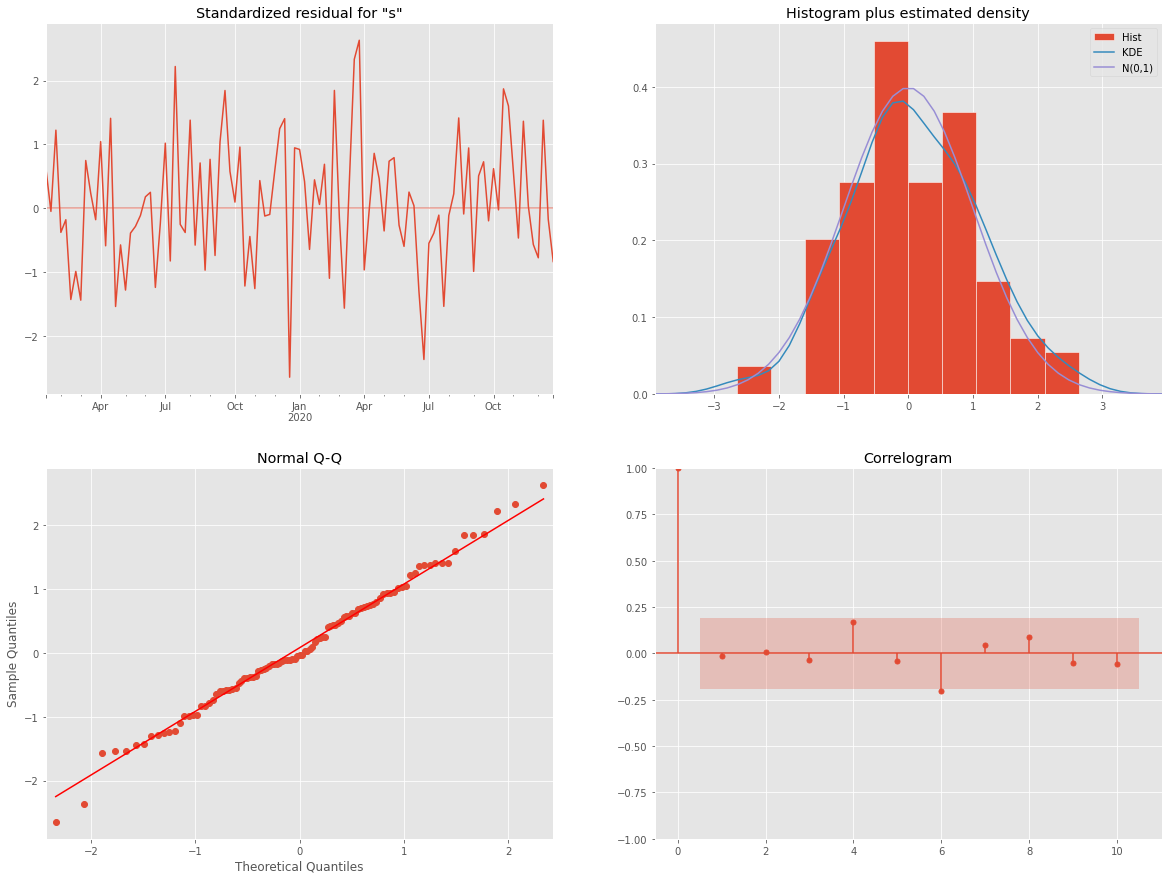

In [97]:
results.plot_diagnostics(figsize=(20, 15))
plt.show()

Оценим точность нашей модели по стандартным метрикам.

In [98]:
predict=results.get_prediction(start='2019-01-14')
metrics(train['2019-01-14':], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -3.702
	P-значение = 0.004
Критические значения :
	1%: -3.506057133647011 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8946066061911946 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5844100201994697 - Данные  стационарны с вероятностью 90% процентов
MAD: 1.6078
MSE: 4.0925
MAPE: 0.1007
MPE: -0.0051
Стандартная ошибка: 2.023


Сделаем прогноз на год вперед и построим график.

In [99]:
predict=results.get_prediction(start='2021', end='2022')

In [100]:
total_df = week_df.copy()
total_df.set_index('ds', inplace=True)

In [93]:
print(results.fittedvalues)

ds
2019-01-07     0.000000
2019-01-14    15.461621
2019-01-21    16.372511
2019-01-28    16.262769
2019-02-04    16.993718
                ...    
2020-11-30    17.194696
2020-12-07    16.420888
2020-12-14    16.810987
2020-12-21    16.898280
2020-12-28    16.540725
Length: 104, dtype: float64


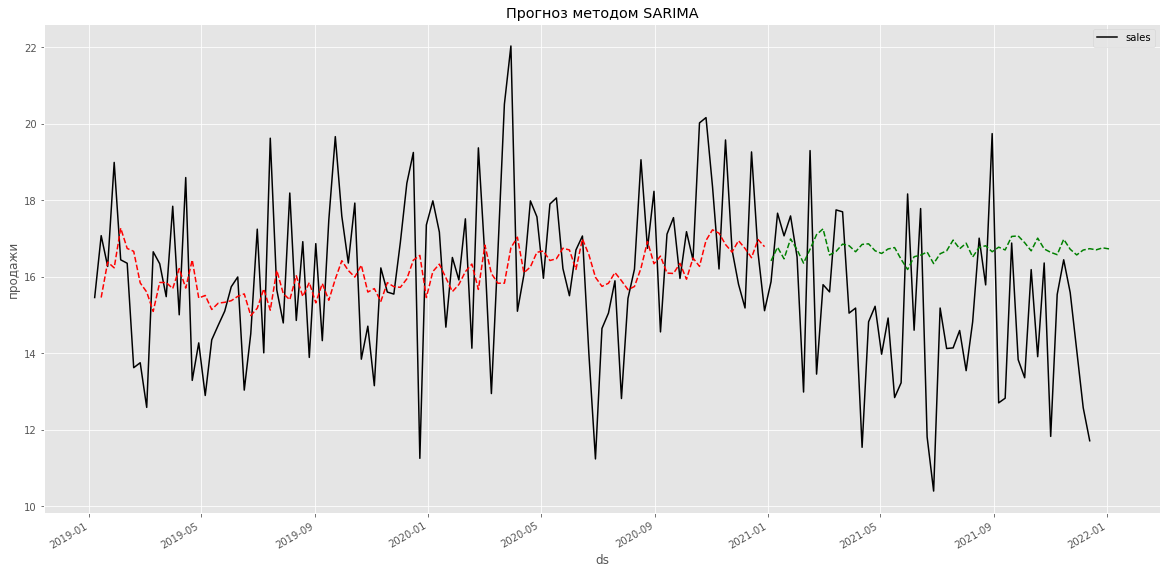

In [101]:
ax = total_df.plot(figsize=(20,10), color='black', title="Прогноз методом SARIMA" )
plt.xlabel("время")
plt.ylabel("продажи")
results.fittedvalues['2019-01-14':].plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()


Оценим модель на точность по тестовым данным

In [102]:
predict=results.get_prediction(start='2021-01-04', end='2021-11-06')
print(len(predict.predicted_mean))
print(len(test))
metrics(test[:-4], predict.predicted_mean)

45
49
Тест на стационарность:
	T-статистика = -6.400
	P-значение = 0.000
Критические значения :
	1%: -3.60098336718852 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.9351348158036012 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6059629803688282 - Данные  стационарны с вероятностью 90% процентов
MAD: 16.7083
MSE: 288.3003
MAPE: 18.5394
MPE: -18.5394
Стандартная ошибка: 16.9794
